# Vesuvius Challenge - 3D UNet Inference

**Pipeline:**
1. Load test volumes (.tif files, any size)
2. Downsample to model size (256³) 
3. Run full volume inference with ensemble
4. Upsample predictions back to actual input size
5. Save predictions as uint8 .tif files
6. Zip all predictions for submission

**Changes in V17:**
- Model trained on full 256³ volumes
- No patch-based inference - uses full 256³ volumes
- Simplified inference pipeline, more memory efficient

In [1]:
!pip uninstall -y tensorflow protobuf
!pip install --no-deps /kaggle/input/wheels-for-vesuvius/monai-1.5.1-py3-none-any.whl
!pip install --no-deps /kaggle/input/wheels-for-vesuvius/imagecodecs-2025.11.11-cp311-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
Processing /kaggle/input/wheels-for-vesuvius/monai-1.5.1-py3-none-any.whl
Processing /kaggle/input/wheels-for-vesuvius/imagecodecs-2025.11.11-cp311-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from monai.networks.nets import UNet
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


## Configuration

In [3]:
class CFG:
    # Data directories
    TEST_IMG_DIR = Path("/kaggle/input/vesuvius-challenge-surface-detection/test_images")
    MODEL_DIR = Path("/kaggle/input/vesuvius-monai-3d-unet-models-v0-2")
    
    # Volume sizes
    MODEL_SIZE = (256, 256, 256)     # Model input size
    
    # Inference settings
    FOLDS = 5
    THRESHOLD = 0.72
    
    # Output settings
    OUTPUT_DIR = Path("./predictions")
    SAVE_VISUALIZATIONS = True  # Set to True to save visualization images
    
    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create output directories
CFG.OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
(CFG.OUTPUT_DIR / "submission_tifs").mkdir(exist_ok=True, parents=True)

print(f"Device: {CFG.DEVICE}")
print(f"Model Size: {CFG.MODEL_SIZE}")
print(f"Threshold: {CFG.THRESHOLD}")
print(f"Visualizations: {CFG.SAVE_VISUALIZATIONS}")

Device: cuda
Model Size: (256, 256, 256)
Threshold: 0.72
Visualizations: True


## Utility Functions

In [4]:
def load_array(path, fmt):
    """Load array from various formats"""
    if fmt == "tiff" or fmt == "tif":
        return tiff.imread(path)
    elif fmt == "npy":
        return np.load(path)
    elif fmt == "npz":
        return np.load(path)["arr_0"]
    elif fmt == "rle":
        rle = np.load(path)
        shape = tuple(rle["shape"])
        vals = rle["vals"]
        runs = rle["runs"]
        flat = np.repeat(vals, runs)
        return flat.reshape(shape)
    else:
        raise ValueError(f"Unsupported format: {fmt}")


def normalize_volume(volume):
    """Normalize volume to zero mean and unit std"""
    volume = volume.astype(np.float32)
    mean = volume.mean()
    std = volume.std()
    return (volume - mean) / (std + 1e-6)


def downsample_volume(volume, target_size):
    """Downsample volume from original size to target size using trilinear interpolation"""
    import torch.nn.functional as F
    
    # Convert to tensor
    vol_tensor = torch.from_numpy(volume).float().unsqueeze(0).unsqueeze(0)
    
    # Downsample using trilinear interpolation
    downsampled = F.interpolate(
        vol_tensor,
        size=target_size,
        mode='trilinear',
        align_corners=False
    )
    
    return downsampled.squeeze(0).squeeze(0).numpy()


def upsample_volume(volume, target_size):
    """Upsample volume from model size back to original size using trilinear interpolation"""
    import torch.nn.functional as F
    
    # Convert to tensor
    vol_tensor = torch.from_numpy(volume).float().unsqueeze(0).unsqueeze(0)
    
    # Upsample using trilinear interpolation
    upsampled = F.interpolate(
        vol_tensor,
        size=target_size,
        mode='trilinear',
        align_corners=False
    )
    
    return upsampled.squeeze(0).squeeze(0).numpy()


def rle_encode(mask):
    """Run-length encoding for submission"""
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Model Architecture

In [5]:
class Ves3DUNet(torch.nn.Module):
    """3D UNet model for surface detection"""
    def __init__(self):
        super().__init__()
        self.model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2, 2),
            num_res_units=3,
            norm='batch'
        )

    def forward(self, x):
        return self.model(x)

## Inference Dataset

In [6]:
class InferenceDataset(Dataset):
    """Dataset for inference on test volumes using full volumes"""
    def __init__(self, image_paths, model_size):
        self.image_paths = image_paths
        self.model_size = model_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Load original volume and get actual shape
        vol = load_array(img_path, "tif")
        actual_shape = vol.shape  # Get actual input shape
        # print(actual_shape)
        
        # Downsample to model size
        vol_downsampled = downsample_volume(vol, self.model_size)
        vol_normalized = normalize_volume(vol_downsampled)
        
        # Convert to tensor [1, D, H, W]
        vol_tensor = torch.from_numpy(vol_normalized).float().unsqueeze(0)
        actual_shape_tensor = torch.tensor(actual_shape, dtype=torch.long)
        
        return {
            'volume': vol_tensor,
            'actual_shape': actual_shape_tensor,
            'filename': img_path.name
        }

## Load Models

In [7]:
def load_models(model_dir, num_folds, device):
    """Load all fold models"""
    models = []
    
    for fold in range(num_folds):
        # Try loading best model first
        model_path = model_dir / f"checkpoints/best_unet3d_fold{fold}.pth"
        
        # Fallback to regular checkpoint if best model not found
        if not model_path.exists():
            model_path = model_dir / f"unet3d_fold{fold}.pth"
        
        if not model_path.exists():
            print(f"Warning: Model for fold {fold} not found at {model_path}")
            continue
            
        model = Ves3DUNet().to(device)
        checkpoint = torch.load(model_path, map_location=device)
        
        # Handle both direct state_dict and checkpoint dict
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
            
        model.eval()
        models.append(model)
        print(f"Loaded model for fold {fold} from {model_path.name}")
    
    print(f"\nTotal models loaded: {len(models)}")
    return models


# Load all trained models
models = load_models(CFG.MODEL_DIR, CFG.FOLDS, CFG.DEVICE)

Loaded model for fold 0 from best_unet3d_fold0.pth
Loaded model for fold 1 from best_unet3d_fold1.pth
Loaded model for fold 2 from best_unet3d_fold2.pth
Loaded model for fold 3 from best_unet3d_fold3.pth
Loaded model for fold 4 from best_unet3d_fold4.pth

Total models loaded: 5


## Inference Function

In [8]:
@torch.no_grad()
def predict_volume(models, volume, device):
    """Predict using ensemble of models on full volume"""
    all_predictions = []
    
    # Add batch dimension [B, C, D, H, W]
    volume = volume.unsqueeze(0).to(device)
    
    # Get predictions from each model
    for model in models:
        model.eval()
        
        with torch.amp.autocast('cuda'):
            pred = model(volume)
            pred = torch.sigmoid(pred).cpu().numpy()[0, 0]  # [D, H, W]
        
        all_predictions.append(pred)
    
    # Ensemble: average predictions from all models
    ensemble_pred = np.mean(all_predictions, axis=0)
    
    return ensemble_pred, all_predictions

## Run Inference on Test Data

In [9]:
# Get test image files (.tif files)
if CFG.TEST_IMG_DIR.exists():
    test_files = sorted([f for f in CFG.TEST_IMG_DIR.glob("*.tif")])
    print(f"Found {len(test_files)} test .tif files")
    
    if len(test_files) > 0:
        print("\nTest files:")
        for f in test_files[:5]:
            print(f"  - {f.name}")
        if len(test_files) > 5:
            print(f"  ... and {len(test_files) - 5} more")
else:
    print(f"Warning: Test directory not found at {CFG.TEST_IMG_DIR}")
    print("Please update CFG.TEST_IMG_DIR to point to the correct directory")
    test_files = []

Found 1 test .tif files

Test files:
  - 1407735.tif


In [10]:
# Run inference and save predictions directly to .tif files
if len(test_files) > 0 and len(models) > 0:
    tif_dir = CFG.OUTPUT_DIR / "submission_tifs"
    processed_count = 0
    
    # Create dataset and dataloader
    test_dataset = InferenceDataset(test_files, CFG.MODEL_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    print("\nRunning inference...\n")
    
    for batch in tqdm(test_loader, desc="Processing volumes"):
        volume = batch['volume'][0]  # [1, D, H, W]
        actual_shape = tuple(batch['actual_shape'][0].numpy())
        filename = batch['filename'][0]
        scroll_id = filename.replace('.tif', '')
        
        # Get ensemble prediction at model size (256^3)
        ensemble_pred_256, _ = predict_volume(models, volume, CFG.DEVICE)
        
        # Upsample to actual input shape
        ensemble_pred_actual = upsample_volume(ensemble_pred_256, actual_shape)
        
        # Create binary mask and ensure uint8 type
        binary_mask = (ensemble_pred_actual > CFG.THRESHOLD).astype(np.uint8)
        
        # Save directly to .tif
        tif_path = tif_dir / f"{scroll_id}.tif"
        tiff.imwrite(tif_path, binary_mask)
        processed_count += 1
        
        # Free memory
        del ensemble_pred_256, ensemble_pred_actual, binary_mask
    
    print(f"\n✓ Inference complete! Saved {processed_count} .tif files to {tif_dir}")
else:
    print("No test files or models available.")
    processed_count = 0


Running inference...



Processing volumes: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


✓ Inference complete! Saved 1 .tif files to predictions/submission_tifs


## Create Submission

In [11]:
import zipfile

# Zip all .tif files for submission
if processed_count > 0:
    tif_dir = CFG.OUTPUT_DIR / "submission_tifs"
    tif_files = sorted(tif_dir.glob("*.tif"))
    zip_path = "submission.zip"
    
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for tif_file in tif_files:
            zipf.write(tif_file, tif_file.name)
    
    print("\n=== Submission Created ===")
    print(f"Files: {len(tif_files)} .tif files")
    print(f"Zip: {zip_path}")
    print(f"Threshold: {CFG.THRESHOLD}")
else:
    print("No predictions to zip.")


=== Submission Created ===
Files: 1 .tif files
Zip: submission.zip
Threshold: 0.72


## Preview Visualizations


=== Binary Mask Previews ===



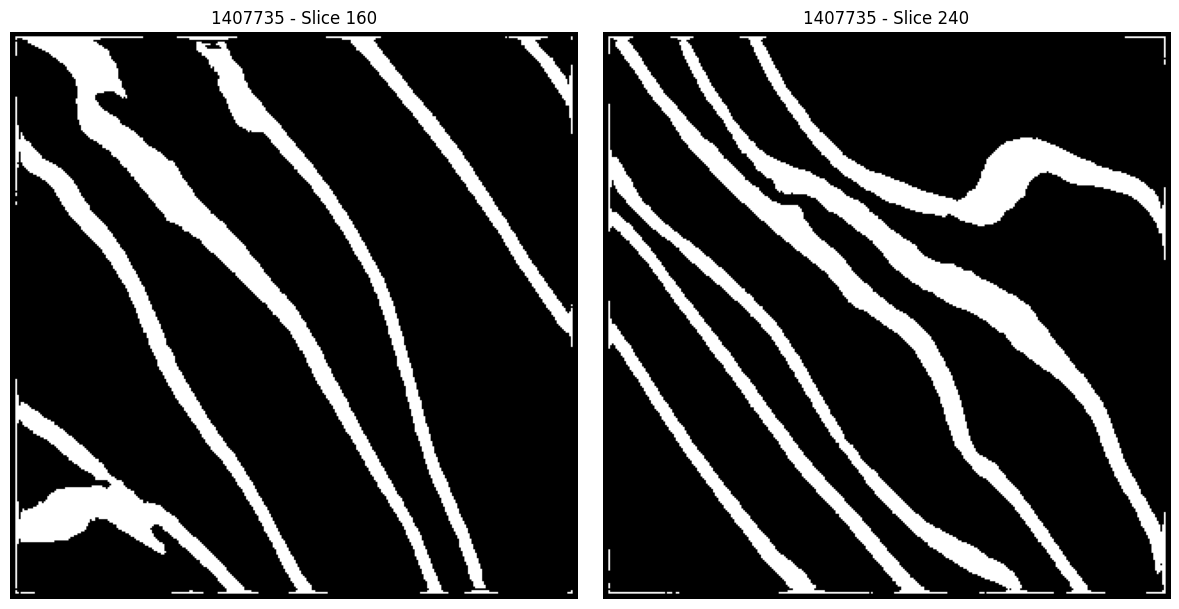


✓ Displayed previews for 1 files


In [12]:
# Display binary mask visualizations (if enabled)
if CFG.SAVE_VISUALIZATIONS and processed_count > 0:
    tif_dir = CFG.OUTPUT_DIR / "submission_tifs"
    tif_files = sorted(tif_dir.glob("*.tif"))[:3]  # Show first 3 files
    
    if tif_files:
        print("\n=== Binary Mask Previews ===\n")
        
        for tif_file in tif_files:
            # Load the binary mask
            binary_mask = tiff.imread(tif_file)
            scroll_id = tif_file.stem
            
            # Show 2 slices
            mid_slice = binary_mask.shape[0] // 2
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            
            axes[0].imshow(binary_mask[mid_slice], cmap='gray')
            axes[0].set_title(f'{scroll_id} - Slice {mid_slice}')
            axes[0].axis('off')
            
            axes[1].imshow(binary_mask[mid_slice + binary_mask.shape[0]//4], cmap='gray')
            axes[1].set_title(f'{scroll_id} - Slice {mid_slice + binary_mask.shape[0]//4}')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
        print(f"\n✓ Displayed previews for {len(tif_files)} files")
    else:
        print("No .tif files found for visualization.")
else:
    if not CFG.SAVE_VISUALIZATIONS:
        print("Visualizations disabled (set CFG.SAVE_VISUALIZATIONS = True to enable)")
    else:
        print("No predictions to visualize.")

## Summary

**Outputs:**
- `predictions/submission_tifs/*.tif` - Binary uint8 masks (actual input size)
- `predictions/submission.zip` - Zipped submission file